In [1]:
import pandas as pd
import numpy as np
from pylab import mpl, plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Data Preparation for Model Training

### Data Reading

In [3]:
start_date = '2016-01-01'
finish_date = '2021-03-01'

price = pd.read_csv("../../data generators/generated_price_data/btc-usd_daily.csv")
price = price[['market','day','close','log_close']]
price.index = price['day']
price = price[(price['day'] >= start_date) & (price['day'] <= finish_date)]

g_trends = pd.read_csv("../../data generators/generated_trends_data/bitcoin_daily.csv")
g_trends = g_trends[['keyword','day','trend','log_trend']]
g_trends.index = g_trends['day']
g_trends = g_trends[(g_trends['day'] >= start_date) & (g_trends['day'] <= finish_date)]

#g_trends2 = pd.read_csv("../../data generators/generated_trends_data/coinbase_daily.csv")
#g_trends2 = g_trends2[['keyword','day','trend','log_trend']]
#g_trends2.index = g_trends2['day']
#g_trends2 = g_trends2[(g_trends2['day'] >= start_date) & (g_trends2['day'] <= finish_date)]

w_pageview = pd.read_csv("../../data generators/generated_wiki_pageview_data/Bitcoin_daily.csv")
w_pageview = w_pageview[['article','day','pageview','log_pageview']]
w_pageview.index = w_pageview['day']
w_pageview = w_pageview[(w_pageview['day'] >= start_date) & (w_pageview['day'] <= finish_date)]

### Data Visualization

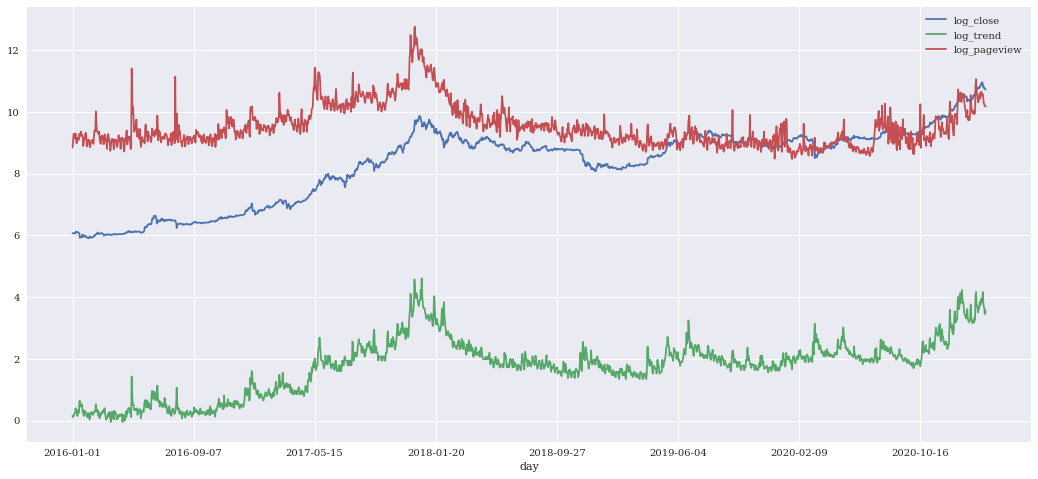

In [4]:
price['log_close'].plot(figsize=(18,8))
g_trends['log_trend'].plot(figsize=(18,8))
#g_trends2['log_trend'].plot(figsize=(18,8))
w_pageview['log_pageview'].plot(figsize=(18,8))
plt.legend()

### Feature Extraction

In [5]:
def create_features(data,key_val,window_len):
    features = np.zeros((1,window_len))
    for t in range(data.shape[0]-window_len):
        d = data[key_val].values[t:t+window_len].reshape(1,window_len)
        
        #Normalization to z-scores
        d = (d-d.mean())/np.std(d)
        features = np.concatenate((features,d))
    return features[1:,:]

## Model Training

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

preds = dict()
models = dict()
window_len_list = [7,10,14]
for exp in range(1):
    for window_len in window_len_list:
        price_features = create_features(price,'close',window_len)
        g_trends_features = create_features(g_trends,'trend',window_len)
        #g_trends2_features = create_features(g_trends2,'trend',window_len)
        w_pageview_features = create_features(w_pageview,'pageview',window_len)

        features = np.hstack((price_features,g_trends_features,w_pageview_features))

        ### Assigning Class Labels

        returns = (price['close'] / price['close'].shift(1))-1
        returns = returns[window_len:]
        classes = np.array([ 1 if r >= 0 else -1 for r in returns ])
        classes = classes.reshape(classes.shape[0],1)

        ### Model Training & Hyperparameter Tuning
        train_len = features.shape[0]-price[price['day'] >= '2019-12-31'].shape[0]
        x_train = features[:train_len,:]
        y_train = classes[:train_len,:]

        x_test = features[train_len:,:]
        y_test = classes[train_len:,:]

        
        random_grid = {'C': [0.1, 1, 5, 10], 'gamma': ['scale','auto'], 'kernel': ['rbf']}

        svc = SVC()
        svc_random = RandomizedSearchCV(estimator = svc, 
                                       param_distributions = random_grid, 
                                       n_iter = 50, 
                                       cv = 4, 
                                       verbose=2, 
                                       random_state=42, 
                                       n_jobs = -1)
        #Fit the random search model
        svc_random.fit(x_train, y_train)

        #Get the best model
        model = svc_random.best_estimator_
        print('svc_w'+str(window_len)+'_exp'+str(exp))
        print('\ttraining score:',model.score(x_train, y_train))
        print('\ttest score:',model.score(x_test,y_test))

        preds['svc_w'+str(window_len)+'_exp'+str(exp)] = model.predict(x_test)[1:]
        models['svc_w'+str(window_len)+'_exp'+str(exp)] = model

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.5s finished


svc_w7_exp0
	training score: 0.9435650378527185
	test score: 0.5667447306791569
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.7s finished


svc_w10_exp0
	training score: 0.7841379310344827
	test score: 0.5480093676814989
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.7s finished


svc_w14_exp0
	training score: 0.9640387275242047
	test score: 0.5597189695550351


## Momentum with Random Forest 

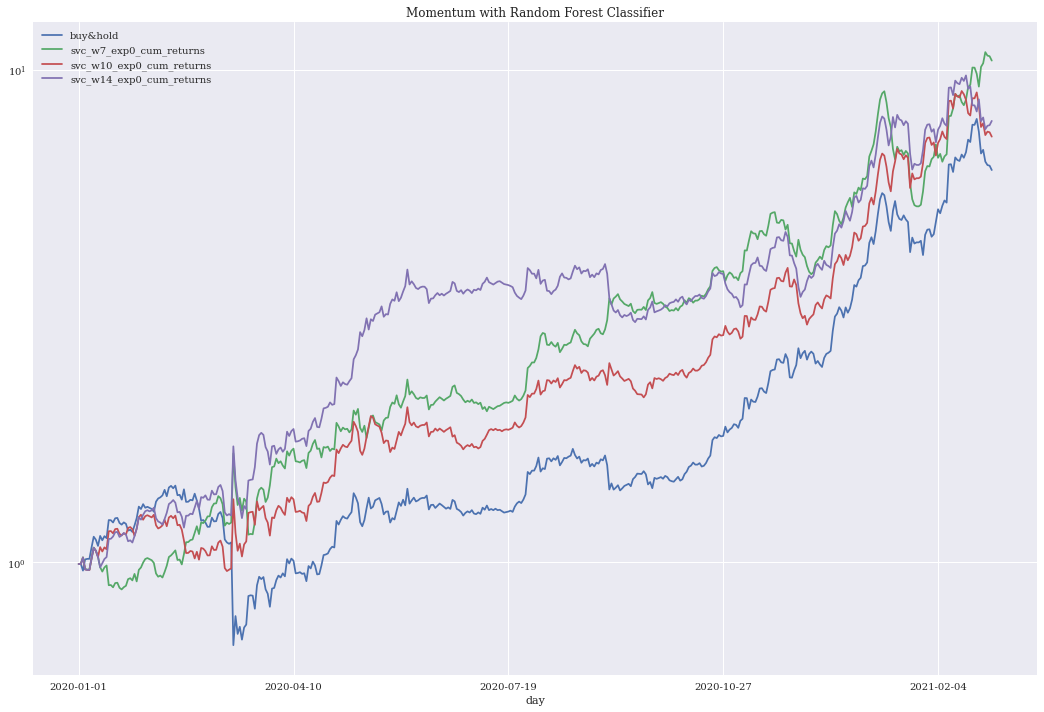

In [13]:
#take proportion of the data
test_data = price[(price['day'] >= '2019-12-31')]

#find buy&hold strategy returns
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
test_data['buy&hold'] = (1+test_data['returns'].values).cumprod()
returns_data = test_data[['returns','buy&hold']].copy()


#find returns
test_data = price[(price['day'] >= '2019-12-31')]
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
for kp in preds.keys():
    test_data[kp+'_returns'] = preds[kp] * test_data['returns']

#find cumulative returns
test_data = test_data[test_data['day'] >= '2020-01-01']
for kp in preds.keys():
    returns_data[kp+'_returns'] = test_data[kp+'_returns'].values
    returns_data[kp+'_cum_returns'] = (1+returns_data[kp+'_returns'].values).cumprod()
    
plot_title = "Momentum with Random Forest Classifier"
plot_columns1 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][:5]
ax = returns_data[plot_columns1].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()


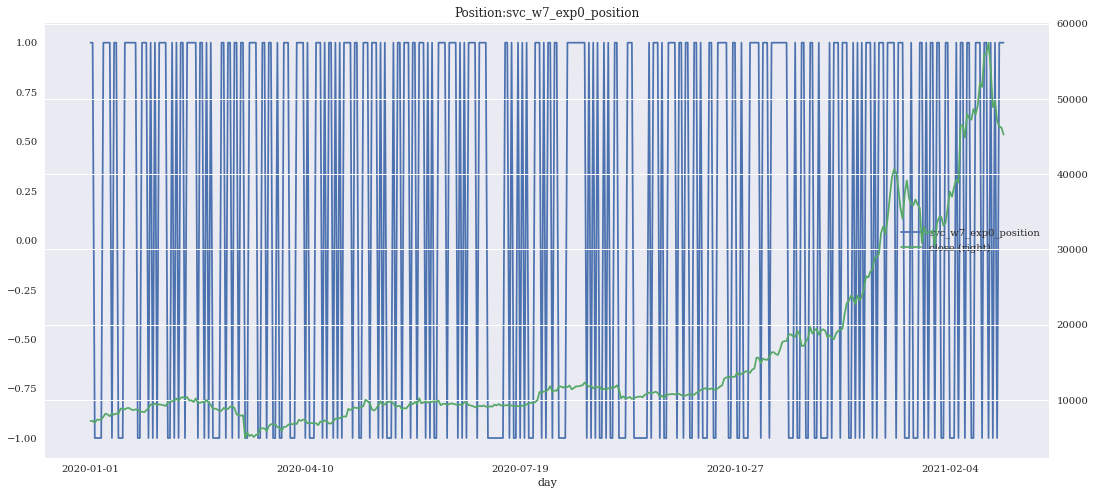

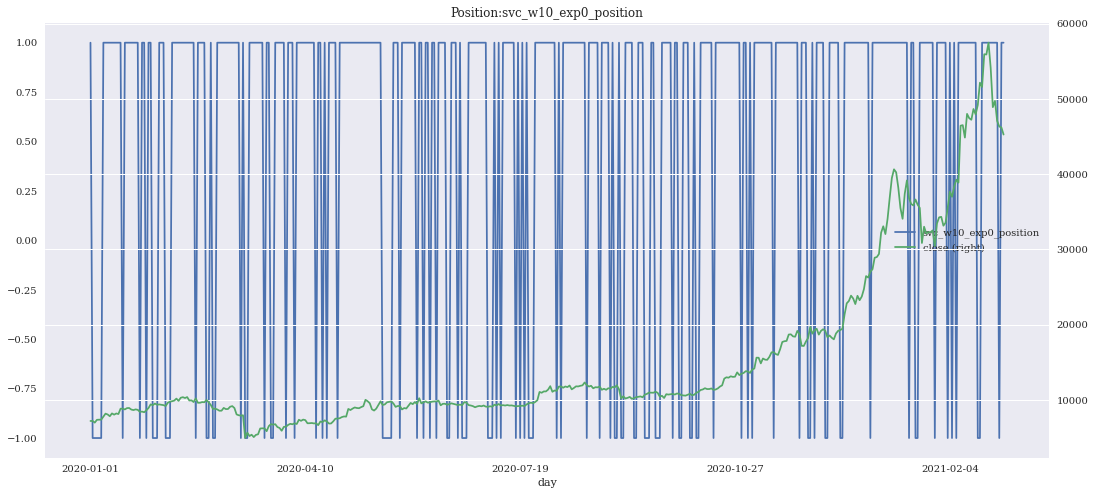

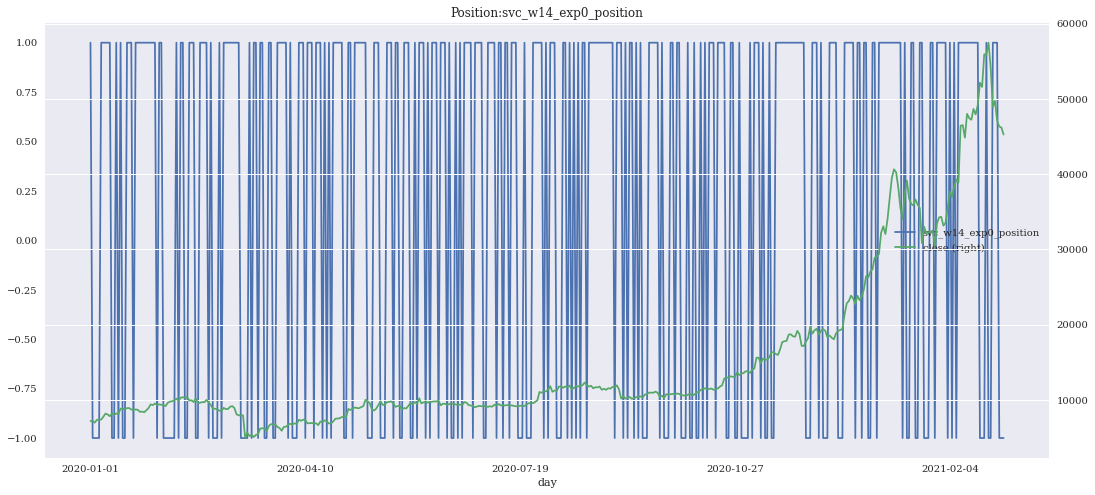

In [14]:
for kp in preds.keys():
    test_data[kp+'_position'] = preds[kp]
    ax = test_data[[kp+'_position','close']].plot(title='Position:'+kp+'_position',secondary_y='close',figsize=(18, 8))

In [15]:
pred_comp_dict = dict()
k = 1
for i,m1 in enumerate(list(models.keys())):
    for j,m2 in enumerate(list(models.keys())):
        if j >= i:
            pred_comp_dict['comp'+str(k)] = {"model1":m1,
                                             "model2":m2,
                                             "comp":models[m1].score(x_test[1:],preds[m2])}
            k += 1

ValueError: X.shape[1] = 42 should be equal to 21, the number of features at training time

In [12]:
pred_comp = pd.DataFrame.from_dict(pred_comp_dict,orient="index")
pred_comp

,model1,model2,comp
comp1,rf_w7_exp0,rf_w7_exp0,1.000000
comp2,rf_w7_exp0,rf_w7_exp1,0.899061
comp3,rf_w7_exp0,rf_w7_exp2,0.941315
comp4,rf_w7_exp0,rf_w7_exp3,0.906103
comp5,rf_w7_exp0,rf_w7_exp4,0.915493
comp6,rf_w7_exp0,rf_w7_exp5,0.927230
comp7,rf_w7_exp0,rf_w7_exp6,0.908451
comp8,rf_w7_exp0,rf_w7_exp7,0.920188
comp9,rf_w7_exp0,rf_w7_exp8,0.931925
comp10,rf_w7_exp0,rf_w7_exp9,0.960094


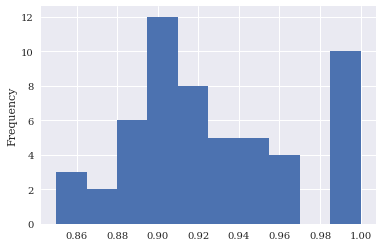

In [13]:
pred_comp['comp'].plot.hist()

In [14]:
result_dict = dict()
i = 0
for m in models.keys():
    result_dict[i] = {'model': m,
                 'cum_r' : returns_data[m+'_cum_returns'].values[-1],
                 'score_tr' : models[m].score(x_train,y_train),
                 'score_ts' : models[m].score(x_test,y_test)}
    i += 1
result_df = pd.DataFrame.from_dict(result_dict,orient='index')
result_df.sort_values(by=['cum_r'],ascending=False)

,model,cum_r,score_tr,score_ts
6,rf_w7_exp6,6.256328,0.553338,0.569087
4,rf_w7_exp4,5.986176,0.637302,0.562061
9,rf_w7_exp9,5.474311,0.686167,0.550351
8,rf_w7_exp8,5.089949,0.627667,0.550351
0,rf_w7_exp0,5.078284,0.695114,0.538642
7,rf_w7_exp7,4.806577,0.814866,0.524590
5,rf_w7_exp5,4.070024,0.583620,0.550351
2,rf_w7_exp2,3.406562,0.695802,0.536300
3,rf_w7_exp3,3.086253,0.644184,0.524590
1,rf_w7_exp1,2.762134,0.735031,0.531616


In [7]:
### Feature Importance Analysis

# 1st 30 -> price features
# 2nd 30 -> google trend kw:bitcoin
# 3rd 30 -> google trend kw:coinbase
# 4th 30 -> wikipedia pageview article: Bitcoin
def print_feature_ranking(model,window_len,feature_count=10,is_print=True):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    def decode_feature_name(i):
        if i >= 0 and i < window_len:
            return "p(t-"+str(window_len-i)+")"
        elif i >= window_len and i < window_len*2:
            return "gtb(t-"+str(window_len-i%window_len)+")"
        elif i >= window_len*2 and i < window_len*3:
            return "gtc(t-"+str(window_len-i%window_len)+")"
        elif i >= window_len*3 and i <window_len*4:
            return "wpb(t-"+str(window_len-i%window_len)+")"

    feature_names = [decode_feature_name(i) for i in indices]

    # Print the feature ranking
    if is_print:
        print("Feature ranking:")
        for f in range(window_len*4):
            print("%d. feature[%d]: %s  (%f) " % (f + 1, indices[f], feature_names[f],importances[indices[f]]))
    
    return feature_names[:feature_count],[importances[indices[i]] for i in range(feature_count)]

<BarContainer object of 10 artists>

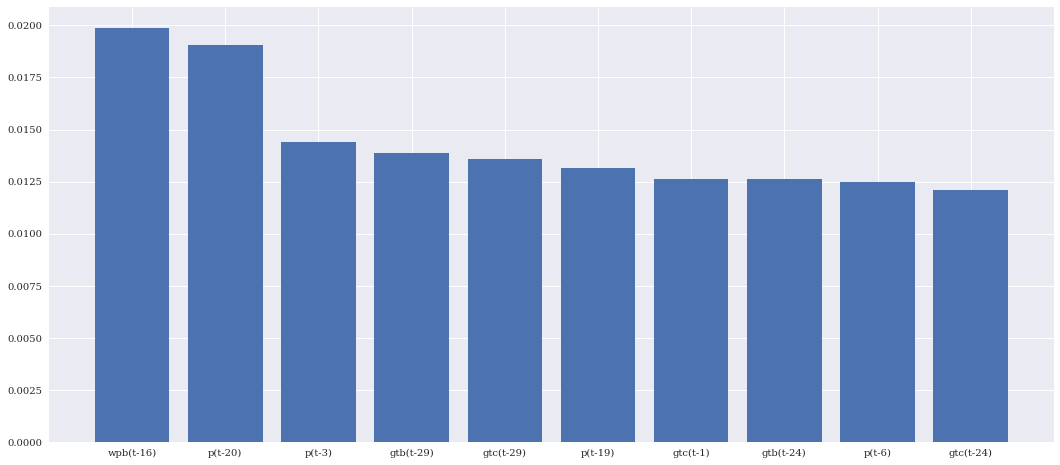

In [11]:
feature_names,importances = print_feature_ranking(model,30,10,False)
plt.figure(figsize=(18,8))
#plt.title()
plt.bar(feature_names,importances)